# Classical and quantum dynamics of electrons in open stadium billiards

In [25]:
import kwant
import scipy
import numpy as np
from matplotlib import pyplot as plt

### Fundamental constants

In [26]:
h = 6.626069e-34    # Planck constant (Js)
h_ = h/(2*np.pi)
e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)
Bfield = 0

## Scaling

In [27]:
asquare = 0.5e-9 # [m] a is the lattice parameter
tsquare = 1.0 # [eV] t is the hopping parameter

scaling = 20 # scaling factor

"""scaling"""

a = asquare * scaling
t = tsquare / scaling**2

## Parameters of the experiment

In [28]:
"Geometrical parameters"

"Fermi energy"
Ef = 10*10**(-3)   # Chosen Fermi energy

side = 2e-6 # Size of the semicircle diameter 
m = h_**2/(2*a**2*t) # Effective mass
k_F = np.sqrt(2*m*Ef/(h_**2)) # Wavevector
v_F = np.sqrt(2*Ef/m) # Fermi velocity
width_leads = 200e-9 # width of the small leads of geometry


"Number of Landau levels"
n = 2

""" Parameter for the zero density zone """
# Dimensions for the zone where we apply a given potential
l_pot = 300e-9
w_pot = 300e-9
Vg =0 
# Vg = 1.1*Ef


print("E_F = ", Ef, "eV")
print("vF = ", v_F)
print("m* = ", m)

E_F =  0.01 eV
vF =  9.482523208224344e+23
m* =  2.2242426650816416e-50


## Verifying of the conditions

In [15]:
""" The wavelength must be (much more) larger than the lattice parameter """
lambda_F = 2 * np.pi * a * np.sqrt(t / Ef) # computation of the wavelength
print("\lambda_F = ", lambda_F)
if lambda_F/a < 2:
    print('Warning : lambda_F must be larger than the lattice parameter a')
    
""" The Fermi energy must be smaller than the hopping parameter t"""
print("E_F = ", Ef)
if Ef/t > 0.5:
    print('Warning : E_F must be smaller than the hopping parameter t')
    

\lambda_F =  3.141592653589793e-08
E_F =  0.01


### Geometry of the device

In [16]:
"Equilateral triangle"
# def geom(pos):
#     x, y = pos
#     m1 = -1/np.sqrt(3)
#     p1 = side/2
#     m2 = 1/np.sqrt(3)
#     p2 = -side/2
#     if x>=0 and x<side*np.sqrt(3)/2 and y>m2*x+p2 and y<m1*x+p1:
#         return True
#     else:
#         return False

"Square"
# def geom(pos):
#     x, y = pos
#     if x>=-side/2 and x<side/2 and y>=-side/2 and y<side/2:
#         return True
#     else:
#         return False
    
"Circle"
# def geom(pos):
#     x, y = pos
#     if (x**2+y**2<side**2/4) :
#         return True
#     else:
#         return False
    
"Stadium"
def geom(pos):
    x, y = pos
    
    frac = 2
    if ( (x-side/frac)**2+y**2<(side/frac)**2) : # x>side/frac and
#         print("Je t'ai vu tout nu")
        return True
    elif ( (x+side/frac)**2+y**2<(side/frac)**2): # x<-side/frac and
        return True
    elif (np.abs(y)<side/frac and np.abs(x)<side/frac) :
        return True
    else:
        return False

## Geometry of the leads

In [17]:
"The vertical shift can be adapted here"
vertical_shift = 0.0e-9

# def lead_shape_left(pos):
#     x, y = pos
#     return -width_leads/2 < y-vertical_shift < width_leads/2

def lead_shape_left(pos):
    x, y = pos
    return -width_leads/2 < x-vertical_shift < width_leads/2


def lead_shape_right(pos):
    x, y = pos
    return -width_leads/2 < y < width_leads/2

#### Defining a zone of zero density in the sample

In [18]:
def onsite(site, Bfield, Vg):
    """
    Definition of the potential. To reach the bottom of the conduction band, the potential is set at 4*t.
    A zone of potential Vg (above the bottom of the conduction band) can be defined in a given zone. 
    
    """
    x, y = site.pos
    
    in_shape = abs(x) < l_pot/2 and y <  w_pot
    
    if in_shape:
        return 4*(t + Vg) + disorder(site)
    else:
        return 4*t + disorder(site)

#### Defining a disorder potential

In [19]:
def disorder(pos):
    x, y = pos
    
    """ Change the definition of pot to include a disorder potential (a function of x and y)"""
    
    pot = 0 
    
#     frac = np.linspace(0,5,50)
#     frac = frac[ind]
#     pot = np.random.normal(loc=0.0, scale=frac*(2*a**2*t*e*Bfield/h_), size=None)
    
    return pot

#### The hopping parameter with magnetic field

In [20]:
def hopping(site_i, site_j, Bfield, Vg):
    xi, yi = site_i.pos
    xj, yj = site_j.pos
    
    hop = t
    
    return hop

### Building the system

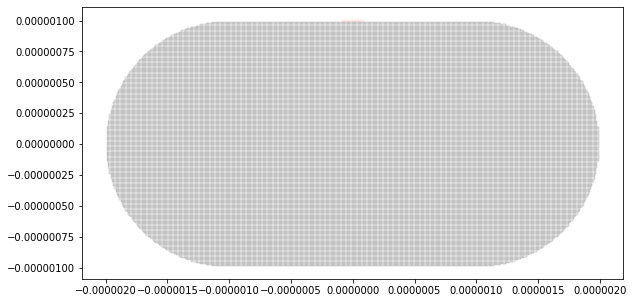

In [21]:
option_axes = 0

def sys_builder(a):
    
    lat = kwant.lattice.square(a, norbs = 1) # norbs gives the number of orbitals per atom. It is needed to compute J

    sys = kwant.Builder() # construction of the system
    
    sys[lat.shape(geom, (0,0))] = onsite # The onsite functions is given in argument
    
    sys[lat.neighbors()] = hopping # the hopping function is given in argument


    """ Lead 1 """
#     sym1 = kwant.TranslationalSymmetry(lat.vec((-1, 0)))
    sym1 = kwant.TranslationalSymmetry(lat.vec((0, 1)))
    lead1 = kwant.Builder(sym1)
    lead1[lat.shape(lead_shape_left, (0,vertical_shift))] = 4*t
    lead1[lat.neighbors()] = hopping
    
    """ The leads are attached """
    sys.attach_lead(lead1)

    sys = sys.finalized()
    
    return sys

"Building and plotting the system"
sys = sys_builder(a)

if (option_axes) :
    "Ajustement des axes en µm (seulement valable pour la cavité side = 3e-6)"
    axes = plt.gca()
    axes.set_xlim(0, 25e-7)
    axes.set_ylim(-15e-7, 15e-7)

    xlabels = ['-1','-0.5','0','0.5','1','1.5','2','2.5']
    ylabels = ['-2','-1.5','-1','-0.5','0','0.5','1','1.5','2']

    axes.set_xticklabels(xlabels)
    axes.set_yticklabels(ylabels)

    axes.axis('equal')
    kwant.plot(sys,ax=axes)
else :
    figure = kwant.plot(sys, site_size = 1e-9, fig_size = (10,5), lead_color = 'r')


## Computing electronic properties in the system
### Defining the magnetic field and the Fermi energy

### Visualisation of the Landau levels

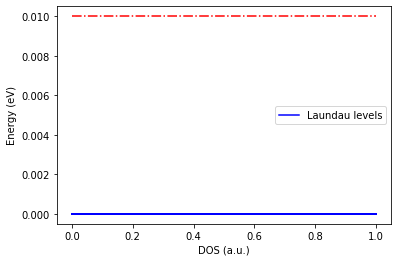

In [22]:
num_LL = 50

plt.figure()

for n in range(num_LL):
    
    En = Vg + 2*a**2*t*e*Bfield*(n+1/2)/h_ 
    
    x = np.array([0, 1]) ; y = En*np.array([1, 1]) # in order to plot the Landau levels
    plt.plot(x, y, 'b')

plt.plot(x, Ef*np.array([1, 1]), 'r-.') # to plot the Fermi energy (in red)

plt.xlabel('DOS (a.u.)')
plt.ylabel('Energy (eV)')
plt.legend(['Laundau levels'], fontsize=10)
plt.show()

### Visualizing the current density

#### Computing the wave function

C:\Users\Leblanc\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: The plotted data contains 1.39% of values overflowing upper limit 357.634 


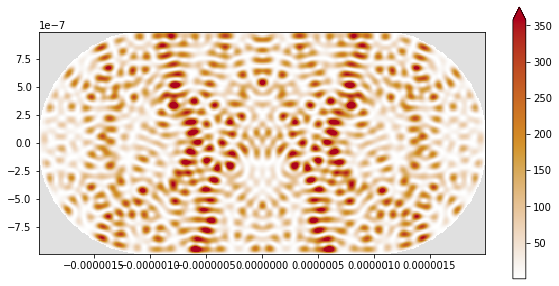

C:\Users\Leblanc\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: The plotted data contains 1.26% of values overflowing upper limit 416.622 


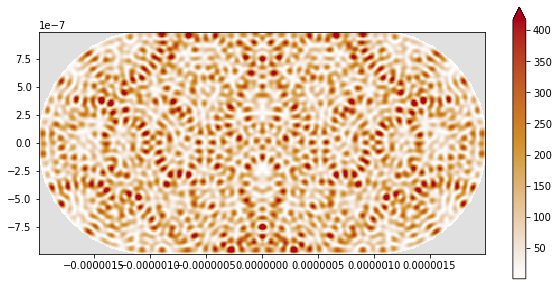

C:\Users\Leblanc\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: The plotted data contains 1.33% of values overflowing upper limit 278.078 


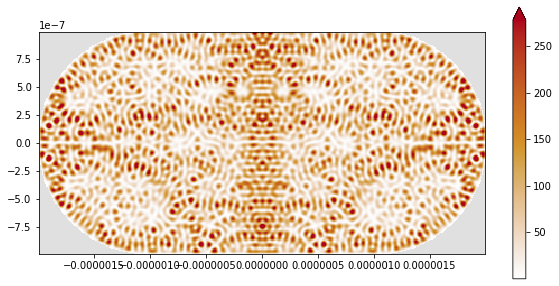

C:\Users\Leblanc\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: The plotted data contains 1.47% of values overflowing upper limit 6661.79 


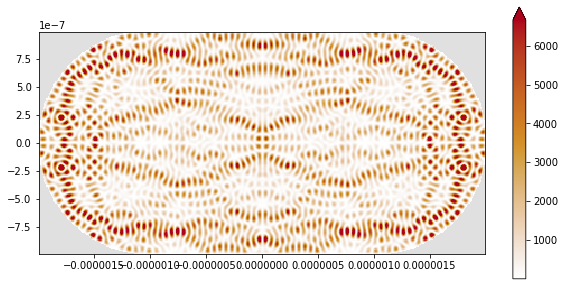

In [23]:
# wfs = kwant.wave_function(sys, energy=Ef, params=dict(Bfield = Bfield, Vg=Vg)) # the wave function is obtained by giving the parameters in arguments       
# scattering_wf = wfs(0)  # all scattering wave functions from lead 1
# kwant.plotter.map(sys, sum(abs(scattering_wf)**2)) # to map the wave function

n_subplots = 5
energies = np.linspace(0.1*10**(-3), 1*10**(-3), n_subplots)

# plt.figure(figsize=(12,4))
# plt.title("The DOS")

for i in range(1, n_subplots):
    Ef = energies[i]
#     plt.subplot(1, n_subplots, i)
    
    wfs = kwant.wave_function(sys, energy=Ef, params=dict(Bfield = Bfield, Vg=Vg)) # the wave function is obtained by giving the parameters in arguments   
    scattering_wf = wfs(0)  # all scattering wave functions from lead 1
    kwant.plotter.map(sys, sum(abs(scattering_wf)**2), fig_size = (10,5)) # to map the wave function
    
# plt.show()

### Computing and plotting the current density

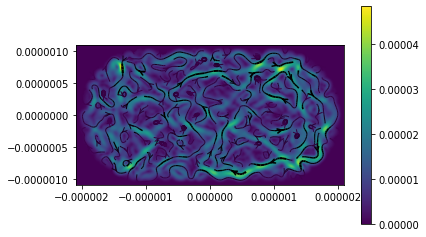

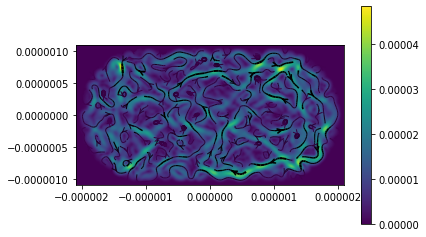

In [24]:
J0 = kwant.operator.Current(sys)
wf_left = wfs(0)
current = sum(J0(p, params=dict(Bfield=Bfield, Vg=Vg)) for p in wf_left) # to sum over all the lead's mode

kwant.plotter.current(sys, current, cmap='viridis')

## Plotting the magnetoresistance as a function of the magnetic field

In [101]:
Bmax = 7*Bc 
print("Bmax = ", Bmax)

Bs = np.linspace(0.1*Bc, Bmax, 50)

Rxxs = np.zeros([len(Bs),1])
num_leads = 2

for i, Bfield in enumerate(Bs):
    
        print("Bfield = ", Bfield)
        s = kwant.smatrix(sys, energy = Ef, params=dict(Bfield=Bfield, Vg = Vg)) # transmission matrix     
#         print("Transmission matrix = ", s.data)
#         print(array[0:3,0:3])
        
        s_mat2 = np.array([[s.transmission(i, j) for j in range(num_leads)] for i in range(num_leads)])
        print("Sij = ", s_mat2)
        G2 = (2*e**2/h)*s_mat2 # Conductance matrix       
    
#         s_mat = np.array([[np.sum(np.square(np.abs(s.data[0:3,0:3]))), np.sum(np.square(np.abs(s.data[3:6,0:3])))],[np.sum(np.square(np.abs(s.data[0:3,3:6]))), np.sum(np.square(np.abs(s.data[3:6,3:6])))]])    
#         G = (2*e**2/h)*s_mat # Conductance matrix  
        
        Rxxs[i] = (1/G2[1][0])/(h/(2*e**2))
        
        print("iteration ", i, " completed")
        
#         Note : la méthode utilisée au TP4 n'est pas nécessaire, car il suffit ici de connaitre la matrice de transmission "s"
#             pour en déduire la matrice de conductance "G" (voir énoncé TP)

# print(Rxxs)

Bmax =  0.30719939418750736
Bfield =  0.004388562774107248
Sij =  [[3.42119435 2.57880565]
 [2.57880565 3.42119435]]
iteration  0  completed
Bfield =  0.010568375660095004
Sij =  [[2.91688755 3.08311245]
 [3.08311245 2.91688755]]
iteration  1  completed
Bfield =  0.016748188546082763
Sij =  [[2.67201841 3.32798159]
 [3.32798159 2.67201841]]
iteration  2  completed
Bfield =  0.02292800143207052
Sij =  [[3.27131876 2.72868124]
 [2.72868124 3.27131876]]
iteration  3  completed
Bfield =  0.029107814318058277
Sij =  [[3.69514119 2.30485881]
 [2.30485881 3.69514119]]
iteration  4  completed
Bfield =  0.03528762720404603
Sij =  [[4.2681883 1.7318117]
 [1.7318117 4.2681883]]
iteration  5  completed
Bfield =  0.041467440090033794
Sij =  [[4.07720953 1.92279047]
 [1.92279047 4.07720953]]
iteration  6  completed
Bfield =  0.04764725297602155
Sij =  [[4.41479927 1.58520073]
 [1.58520073 4.41479927]]
iteration  7  completed
Bfield =  0.053827065862009305
Sij =  [[4.23226125 1.76773875]
 [1.76773875

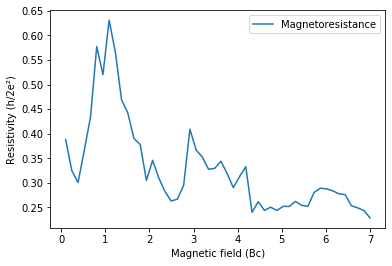

Rxxs =  [[0.38777641]
 [0.32434756]
 [0.30048243]
 [0.3664774 ]
 [0.43386606]
 [0.57742998]
 [0.52007747]
 [0.63083494]
 [0.56569445]
 [0.46876786]
 [0.44237707]
 [0.39000595]
 [0.37812764]
 [0.30484438]
 [0.34562866]
 [0.30964916]
 [0.28184022]
 [0.26287831]
 [0.26672688]
 [0.29523106]
 [0.40904404]
 [0.36667916]
 [0.35238532]
 [0.32743552]
 [0.32932656]
 [0.34386801]
 [0.31855374]
 [0.28999342]
 [0.31271025]
 [0.33273405]
 [0.23981158]
 [0.26149125]
 [0.24369584]
 [0.25027066]
 [0.24352159]
 [0.25193855]
 [0.25186646]
 [0.26210662]
 [0.25398694]
 [0.25216472]
 [0.28040234]
 [0.28891   ]
 [0.28754951]
 [0.2835681 ]
 [0.27756845]
 [0.27587815]
 [0.25318577]
 [0.24902124]
 [0.24355816]
 [0.22845236]]


In [102]:
plt.figure()
plt.plot(Bs/Bc, Rxxs, label = 'Magnetoresistance')
plt.legend()

plt.xlabel('Magnetic field (Bc)')
plt.ylabel('Resistivity (h/2e²)')

plt.show()

print("Rxxs = ", Rxxs)

In [347]:
###############################################################################################################################
##############################################################################################################################
##############################################################################################################################

In [13]:
Bmax = 7*Bc
Bs = np.linspace(0.1*Bc, Bmax, 150)

for i in Bs :
    print(i)
# print(Bs[100])

0.004388562774107248
0.006420850233257584
0.00845313769240792
0.010485425151558255
0.012517712610708592
0.014550000069858928
0.016582287529009265
0.0186145749881596
0.020646862447309938
0.022679149906460274
0.02471143736561061
0.026743724824760947
0.02877601228391128
0.030808299743061617
0.03284058720221195
0.03487287466136229
0.036905162120512626
0.03893744957966296
0.0409697370388133
0.043002024497963635
0.04503431195711397
0.04706659941626431
0.049098886875414645
0.05113117433456498
0.05316346179371531
0.05519574925286565
0.057228036712015984
0.05926032417116632
0.06129261163031666
0.063324899089467
0.06535718654861733
0.06738947400776767
0.069421761466918
0.07145404892606834
0.07348633638521868
0.07551862384436901
0.07755091130351935
0.07958319876266969
0.08161548622182002
0.08364777368097036
0.0856800611401207
0.08771234859927103
0.08974463605842137
0.0917769235175717
0.09380921097672204
0.09584149843587238
0.09787378589502271
0.09990607335417305
0.10193836081332337
0.103970648272

## Adding disorder

In [56]:
Bfield = Bc

Rxxs = np.zeros([50,1])
num_leads = 2

for i in range(0,50):
    ind = i
    
    "Building and plotting the system"
    sys = sys_builder(a)
    s = kwant.smatrix(sys, energy = Ef, params=dict(Bfield=Bfield, Vg = Vg)) # transmission matrix     

    s_mat2 = np.array([[s.transmission(i, j) for j in range(num_leads)] for i in range(num_leads)])
    print("Sij = ", s_mat2)
    G2 = (2*e**2/h)*s_mat2 # Conductance matrix       

    Rxxs[i] = (1/G2[1][0])/(h/(2*e**2))

    print(Rxxs[i])
    print("iteration ", i, " completed")

Putting left lead in the middle of left-side
Sij =  [[3.8344693 2.1655307]
 [2.1655307 3.8344693]]
[0.46178057]
iteration  0  completed
Putting left lead in the middle of left-side
Sij =  [[3.83402259 2.16597741]
 [2.16597741 3.83402259]]
[0.46168533]
iteration  1  completed
Putting left lead in the middle of left-side
Sij =  [[3.80333128 2.19666872]
 [2.19666872 3.80333128]]
[0.45523478]
iteration  2  completed
Putting left lead in the middle of left-side
Sij =  [[3.87714589 2.12285411]
 [2.12285411 3.87714589]]
[0.47106393]
iteration  3  completed
Putting left lead in the middle of left-side
Sij =  [[3.88371925 2.11628075]
 [2.11628075 3.88371925]]
[0.4725271]
iteration  4  completed
Putting left lead in the middle of left-side
Sij =  [[3.85028651 2.14971349]
 [2.14971349 3.85028651]]
[0.46517827]
iteration  5  completed
Putting left lead in the middle of left-side
Sij =  [[3.85931668 2.14068332]
 [2.14068332 3.85931668]]
[0.46714056]
iteration  6  completed
Putting left lead in the 

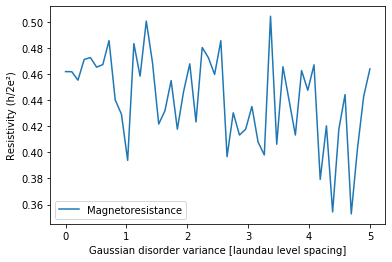

Rxxs =  [[0.46178057]
 [0.46168533]
 [0.45523478]
 [0.47106393]
 [0.4725271 ]
 [0.46517827]
 [0.46714056]
 [0.48552374]
 [0.44006128]
 [0.42914587]
 [0.39383494]
 [0.48320432]
 [0.4583035 ]
 [0.50045216]
 [0.46856645]
 [0.42164647]
 [0.43179501]
 [0.45489749]
 [0.4176687 ]
 [0.44639964]
 [0.4677446 ]
 [0.42322641]
 [0.48024166]
 [0.47237266]
 [0.45961653]
 [0.4854248 ]
 [0.39666002]
 [0.43026082]
 [0.41319529]
 [0.41773985]
 [0.4350608 ]
 [0.40783482]
 [0.39799744]
 [0.50414869]
 [0.40618103]
 [0.4654771 ]
 [0.43948816]
 [0.41320832]
 [0.46258223]
 [0.44748325]
 [0.46695459]
 [0.37924702]
 [0.42027958]
 [0.35436979]
 [0.4176424 ]
 [0.44419744]
 [0.35284523]
 [0.40294949]
 [0.44288305]
 [0.46383446]]


In [58]:
plt.figure()
plt.plot(np.linspace(0,5,50), Rxxs, label = 'Magnetoresistance')
plt.legend()

plt.xlabel('Gaussian disorder variance [laundau level spacing]')
plt.ylabel('Resistivity (h/2e²)')

plt.show()

print("Rxxs = ", Rxxs)